# Case study: queue analysis

This case study illustrates the use of the staircase package for queue analysis.  In this example we have a number of vessels (i.e. ships) which arrive offshore and await their turn to enter a harbour where they will be loaded with cargo.  We will examine the queue, which is composed of all vessels which are offshore but yet to enter the harbour, for the year 2020.

The data used is this case study is synthetic and fictional.  Both data and the notebook for this tutorial can be obtained from the [github site](https://github.com/venaturum/staircase/tree/master/docs/examples).

In [1]:
import pandas as pd
import staircase as sc
import matplotlib.pyplot as plt

We begin by importing the queue data into a pandas.DataFrame instance. Each row corresponds to a vessel. The first column gives the time at which the vessel arrives offshore (enters the queue), and the second column gives the time at which the vessel enters the harbour (leaves the queue).  A [NaT](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#datetimes) value in either of these columns indicates the vessel entered the queue prior to 2020, or left the queue after 2020, however this approach does not require these values to be NaT.  The third column gives the weight of cargo destined for the vessel.  Note, for the staircase approach to work we require every vessel, that was in the queue at some point in 2020, to appear in the dataframe.

In [2]:
data = pd.read_csv(r"data/vessel_queue.csv", parse_dates=['enter', 'leave'], dayfirst=True)
data

,enter,leave,tonnes
0,NaT,2020-01-01 04:40:00,129000
1,NaT,2020-01-01 22:18:00,69055
2,NaT,2020-01-01 11:47:00,138000
3,NaT,2020-01-02 10:12:00,84600
4,NaT,2020-01-01 22:39:00,142550
...,...,...,...
1224,2020-12-29 05:59:00,NaT,142500
1225,2020-12-29 17:41:00,NaT,84600
1226,2020-12-30 12:41:00,NaT,119200
1227,2020-12-30 16:59:00,NaT,113200


The layer method can be used with array-like parameters.  The creation of a step function to quantify the size of the queue is as simple as calling the layer method with a vector of times that vessels enter the queue, and a vector of times that vessels leave the queue - the columns "enter" and "leave" respectively:

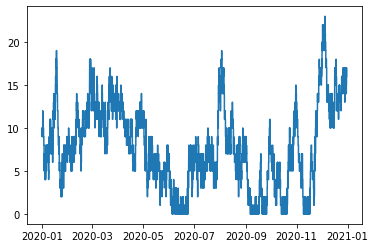

In [3]:
queue = sc.Stairs(use_dates=True).layer(data.enter, data.leave)
queue.plot()

Assuming that no vessels arrive precisely at midnight on the 1st of Jan, we expect the number of vessels in the queue at this time to be equal to the number of NaT values in the "enter" column:

In [4]:
queue(pd.Timestamp('2020-01-01'))

10

In [5]:
data.enter.isna().sum()

10

The Stairs class comes with a hist function (histogram) which can be pretty useful for understanding the distribution of the values of the corresponding step function.  The result is returned as a pandas.Series, indexed by a pandas.IntervalIndex.  If we don't supply the bins as a parameter it will use unit bins which cover the step function's range:

In [6]:
queue_hist = queue.hist(pd.Timestamp('2020'), pd.Timestamp('2021'))
queue_hist

[0, 1)      0.090418
[1, 2)      0.043205
[2, 3)      0.029688
[3, 4)      0.039870
[4, 5)      0.048759
[5, 6)      0.084548
[6, 7)      0.085024
[7, 8)      0.093790
[8, 9)      0.078144
[9, 10)     0.048905
[10, 11)    0.053679
[11, 12)    0.062805
[12, 13)    0.060775
[13, 14)    0.051981
[14, 15)    0.036320
[15, 16)    0.027256
[16, 17)    0.026677
[17, 18)    0.017746
[18, 19)    0.007252
[19, 20)    0.002284
[20, 21)    0.003338
[21, 22)    0.005897
[22, 23)    0.001510
[23, 24)    0.000127
dtype: float64

We know the queue length has to be a whole number so we can change the pandas.IntervalIndex accordingly before plotting

''

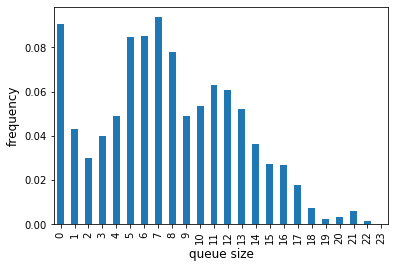

In [7]:
queue_hist.index = queue_hist.index.left
ax = queue_hist.plot.bar()
ax.set_xlabel('queue size', fontsize='12')
ax.set_ylabel('frequency', fontsize='12')
;

Another useful queue metric is the "queue tonnes".  This is the sum of the cargo tonnes destined for vessels in the queue.  A step function representing this variable is also straightforward by using the third parameter of the layer method - the values representing how much the step function should increase or decrease whenever the corresponding vessels enter or leave the queue:

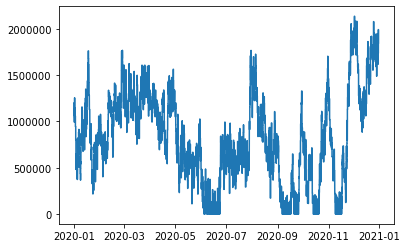

In [8]:
queue_tonnes = sc.Stairs(use_dates=True).layer(data.enter, data.leave, data.tonnes)
queue_tonnes.plot()

We can use this queue_tonnes object to answer questions like "what was the maximum queue tonnes in 2020?"

In [9]:
queue_tonnes.max()

2138466

.. or "what was the average size of the queue in 2020?"

In [10]:
queue_tonnes.mean(pd.Timestamp('2020'), pd.Timestamp('2021'))

817852.3209585852

or "what fraction of the year was the queue_tonnes larger than 1,500,000 tonnes?"

In [11]:
(queue_tonnes > 1500000).mean(pd.Timestamp('2020'), pd.Timestamp('2021'))

0.09867751973285666

.. or "what was the median size of the queue in March 2020?"

In [12]:
queue_tonnes.median(pd.Timestamp('2020-3-1'), pd.Timestamp('2020-4-1'))

1281300.0

The median gives us the 50th percentile, but we might be interested in the 80th percentile?  We can do that:

In [13]:
queue_tonnes.percentile(80, pd.Timestamp('2020-3-1'), pd.Timestamp('2020-4-1'))

1420500.0

In fact we can even get a percentile function, represented by a Stairs object itself.

In [14]:
percentile = queue_tonnes.percentile_stairs(pd.Timestamp('2020'), pd.Timestamp('2021'))
percentile

<staircase.Stairs, id=1759980419400, dates=False>

We can plot this function of course, since it is represented by a Stairs object:

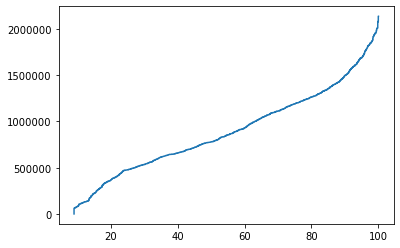

In [15]:
percentile.plot()

The 100th percentile should be the same as the maximum queue tonnes we found earlier.  Let's check:

In [16]:
percentile(100) == queue_tonnes.max()

True

What is the 40th, 65th, 77th and 90th percentiles?  The sample method, which is aliased by \_\_call\_\_, can be called with a vector of values at which to evaluate the step function too.

In [17]:
percentile([40, 65, 77, 90])

[659500, 1035400, 1220600, 1496800]

The percentile function is essentially the inverse of an [empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function).  Perhaps, unsurprisingly we can generate an ecdf like so:

In [18]:
ecdf = queue_tonnes.ecdf_stairs(pd.Timestamp('2020'), pd.Timestamp('2021'))
ecdf

<staircase.Stairs, id=1759980573192, dates=False>

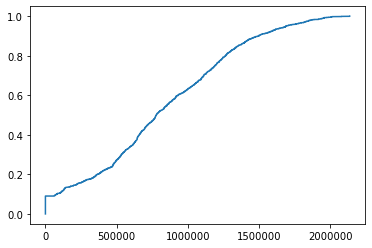

In [19]:
ecdf.plot()

Earlier we found that the queue tonnes were strictly above 150,000t about 9.87% of the time.  The ecdf can tell us what fraction of the time the queue tonnes was less than or equal to 150,000t.  (We'd expect these results to add to 1).

In [20]:
ecdf(1500000)

0.9013224802671564

We can also then discover the fraction of time that 100,000 < queue tonnes <= 150,000 like so:

In [21]:
ecdf(1500000) - ecdf(100000)

0.7969622799028576

This sort of information is essentially a single bin in histogram data.  Earlier we used the Stairs.hist function on the queue length, with default bin sizes.  Since the range of the queue tonnes values is so large we will provide our own bins (defined by specifiying the edges) to generate a histogram for the queue tonnes.

In [22]:
queue_tonnes_hist = queue_tonnes.hist(pd.Timestamp('2020'), pd.Timestamp('2021'), bin_edges = range(0, 2100000, 100000))
queue_tonnes_hist

[0, 100000)           0.104360
[100000, 200000)      0.040817
[200000, 300000)      0.029093
[300000, 400000)      0.040346
[400000, 500000)      0.057899
[500000, 600000)      0.069479
[600000, 700000)      0.094911
[700000, 800000)      0.080645
[800000, 900000)      0.062583
[900000, 1000000)     0.050406
[1000000, 1100000)    0.059751
[1100000, 1200000)    0.064855
[1200000, 1300000)    0.066940
[1300000, 1400000)    0.045719
[1400000, 1500000)    0.033519
[1500000, 1600000)    0.027588
[1600000, 1700000)    0.023567
[1700000, 1800000)    0.014984
[1800000, 1900000)    0.016359
[1900000, 2000000)    0.011215
dtype: float64

As we did earlier for the queue length histogram, we can quickly create a chart with pandas Series plotting functions.

''

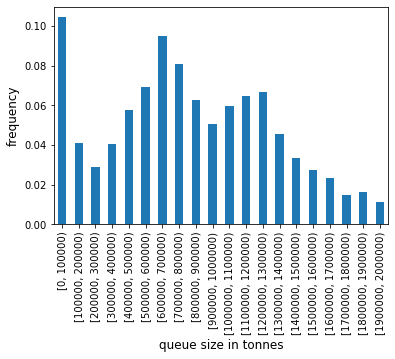

In [23]:
ax = queue_tonnes_hist.plot.bar()
ax.set_xlabel('queue size in tonnes', fontsize='12')
ax.set_ylabel('frequency', fontsize='12')
;

Returning to our queue plots... They're pretty noisy. We can reduce some of this noise by using the rolling_mean method belonging to the Stairs class.  The method uses the fact that a rolling mean of a piecewise constant function, i.e. a step function, will be a piecewise linear function.  And a piecewise linear function can be described by the (x,y) coordinates at each end of the "pieces".  The result is returned as a pandas.Series.

In this example we apply a rolling mean with a 7 day, centred, window around every point in the step function.  We do this by specifying the window with a tuple, detailing the distances from the point to the boundaries of thw window - in this case, 3.5 days either side of the point.

In [24]:
queue.rolling_mean(window=(-pd.Timedelta(3.5, 'D'), pd.Timedelta(3.5, 'D')))

2019-12-28 16:40:00    10.000000
2019-12-28 21:35:00     9.970734
2019-12-28 23:47:00     9.970734
2019-12-29 05:29:00     9.936806
2019-12-29 08:47:00     9.936806
                         ...    
2021-01-02 17:35:00    15.891071
2021-01-03 00:41:00    15.975595
2021-01-03 04:59:00    16.001190
2021-01-03 05:59:00    16.001190
2021-01-03 06:11:00    16.000000
Length: 4812, dtype: float64

Note that our original data was contained to the year 2020 but the data in our rolling mean has spilled over into 2019, and 2020.  This is because our step function theoretically extends to -infinity and +infinity.  In this case this effect is unwanted.  Similar to the application of rolling means with pandas.Series, we will actually have to sacrifice some of our "usable domain" to create the rolling mean. We do this by specifying a domain of our step function when applying the rolling mean:

In [25]:
queue.rolling_mean(
    window=(-pd.Timedelta(3.5, 'D'), pd.Timedelta(3.5, 'D')),
    lower=pd.Timestamp('2020'),
    upper=pd.Timestamp('2021'),
)

2020-01-04 12:00:00     7.346925
2020-01-04 14:35:00     7.300794
2020-01-04 15:13:00     7.293254
2020-01-04 16:40:00     7.267361
2020-01-04 21:19:00     7.212004
                         ...    
2020-12-27 23:53:00    15.389286
2020-12-28 02:29:00    15.435714
2020-12-28 09:29:00    15.519048
2020-12-28 10:05:00    15.522619
2020-12-28 12:00:00    15.522619
Length: 4724, dtype: float64

Now we can see that we only have dates in our rolling mean data where the window entirely fits within the domain we specified.  The real use of this data is realised when plotting, and we can leverage the [plot function of pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html) to this effect.

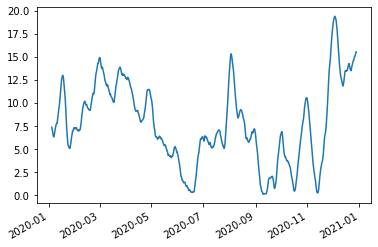

In [26]:
queue.rolling_mean(
    window=(-pd.Timedelta(3.5, 'D'), pd.Timedelta(3.5, 'D')),
    lower=pd.Timestamp('2020'),
    upper=pd.Timestamp('2021'),
).plot()

We can see that applying the rolling window has removed the noise and allowed us to look at trend.  We can get an ever coarser trend by using a larger window, for example 30 day centred window results in the following graph.

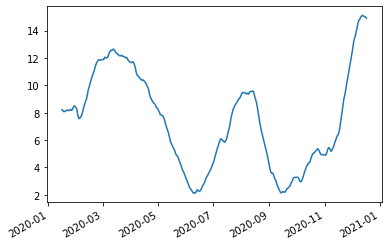

In [27]:
queue.rolling_mean(
    window=(-pd.Timedelta(15, 'D'), pd.Timedelta(15, 'D')),
    lower=pd.Timestamp('2020'),
    upper=pd.Timestamp('2021'),
).plot()

Another method to remove noise is to apply a static mean, rather than a rolling mean.  For example, we could use calculate a daily mean.  To achieve this let's use Python's zip function, list comprehension and a pandas.Series to derive and collect this data:

In [28]:
yr2020 = pd.date_range('2020', '2021')
daily_mean_queue = pd.Series(
    [queue.mean(d1,d2) for d1,d2 in zip(yr2020[:-1], yr2020[1:])],
    index = yr2020[:-1]
)
daily_mean_queue

2020-01-01     9.673611
2020-01-02    10.056944
2020-01-03     7.490278
2020-01-04     5.312500
2020-01-05     5.288194
                ...    
2020-12-27    15.424306
2020-12-28    14.813194
2020-12-29    16.374306
2020-12-30    15.004861
2020-12-31    16.000000
Freq: D, Length: 366, dtype: float64

A new way to achieve the exact same result, as of v1.5.0, is to use the sample method.  The sample method was used earlier to calculate the 40th, 65th, 77th and 90th percentiles for queue_tonnes, however we accessed it via its alias \_\_call\_\_ which allows us to simply write () instead of sample(). The sample method has been extended to be able to specify an aggregating function, and a window, similar to the rolling mean.  If we apply the mean function, and a 1 day leading window, then we get exactly the same result as the cell above (and it runs slightly faster too). 

In [29]:
pd.Series(
    queue.sample(yr2020[:-1], aggfunc='mean', window=(pd.Timedelta(0), pd.Timedelta(1, 'D'))),
    index = yr2020[:-1],
)

2020-01-01     9.673611
2020-01-02    10.056944
2020-01-03     7.490278
2020-01-04     5.312500
2020-01-05     5.288194
                ...    
2020-12-27    15.424306
2020-12-28    14.813194
2020-12-29    16.374306
2020-12-30    15.004861
2020-12-31    16.000000
Freq: D, Length: 366, dtype: float64

As with the rolling mean, this data is best interpreted with a plot:

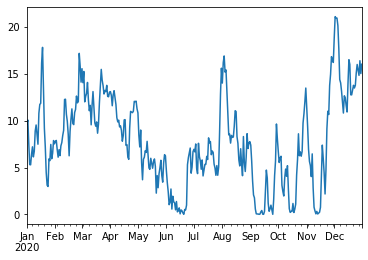

In [30]:
daily_mean_queue.plot()

This time we can use [pandas.Series.rolling](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html) to get a rolling mean - although this will be a rolling mean of daily averages.  This data can of course be plotted with [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org/), but for now let's keep leveraging the pandas.Series plotting methods:

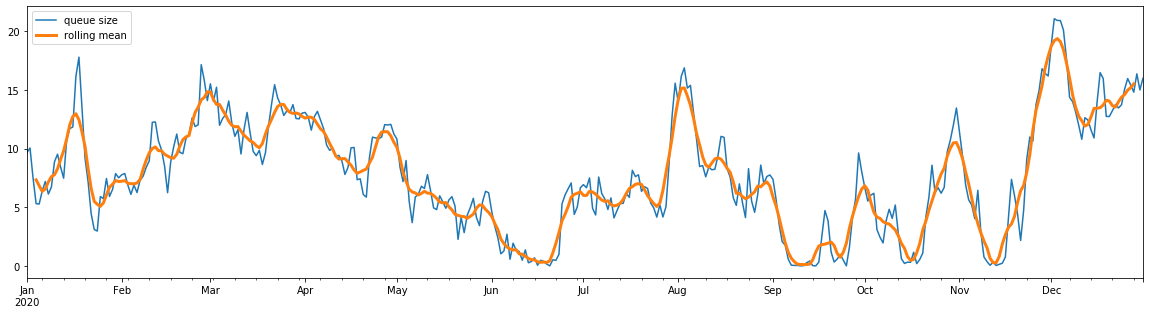

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
daily_mean_queue.plot(ax=ax, label="queue size")
daily_mean_queue.rolling(7, center=True).mean().plot(ax=ax, linewidth=3, label="rolling mean")
ax.legend()